In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.2 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, MultiHeadAttention, LayerNormalization, Lambda
from tensorflow.keras.applications import Xception, MobileNetV3Small, EfficientNetB7, ResNet101
import optuna
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import time

In [5]:
# Setting random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Students Social Media Addiction.csv')

# Data Preprocessing
data = data.dropna()

In [6]:
# Encode categorical variables
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])
data['Academic_Level'] = le.fit_transform(data['Academic_Level'])
data['Country'] = le.fit_transform(data['Country'])
data['Most_Used_Platform'] = le.fit_transform(data['Most_Used_Platform'])
data['Affects_Academic_Performance'] = le.fit_transform(data['Affects_Academic_Performance'])
data['Relationship_Status'] = le.fit_transform(data['Relationship_Status'])

# Discretize Addicted_Score
def discretize_addiction(score):
    if score <= 3:
        return 0  # Low
    elif score <= 6:
        return 1  # Medium
    else:
        return 2  # High

data['Addicted_Score_Category'] = data['Addicted_Score'].apply(discretize_addiction)

# Features and target
X = data.drop(['Student_ID', 'Addicted_Score', 'Addicted_Score_Category'], axis=1)
y = data['Addicted_Score_Category']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Reshape for 1D CNN
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Pad for image-based models (32x32x3 for MobileNetV3, EfficientNetB7, ResNet101; 71x71x3 for Xception)
features = X_train.shape[1]
image_size = 32  # For MobileNetV3, EfficientNetB7, ResNet101
repeat_factor = max(1, (image_size + features - 1) // features)
X_train_repeated = np.repeat(X_train, repeat_factor, axis=1)[:, :image_size]
X_test_repeated = np.repeat(X_test, repeat_factor, axis=1)[:, :image_size]
X_train_image = X_train_repeated.reshape(X_train.shape[0], image_size, 1)
X_test_image = X_test_repeated.reshape(X_test.shape[0], image_size, 1)
X_train_image = np.repeat(X_train_image, 3, axis=2)  # (samples, image_size, 3)
X_test_image = np.repeat(X_test_image, 3, axis=2)
X_train_image = np.repeat(X_train_image[:, :, np.newaxis, :], image_size, axis=2)  # (samples, image_size, image_size, 3)
X_test_image = np.repeat(X_test_image[:, :, np.newaxis, :], image_size, axis=2)

# Pad for Xception (71x71x3)
xception_size = 71
repeat_factor_xception = max(1, (xception_size + features - 1) // features)
X_train_repeated_xception = np.repeat(X_train, repeat_factor_xception, axis=1)[:, :xception_size]
X_test_repeated_xception = np.repeat(X_test, repeat_factor_xception, axis=1)[:, :xception_size]
X_train_xception = X_train_repeated_xception.reshape(X_train.shape[0], xception_size, 1)
X_test_xception = X_test_repeated_xception.reshape(X_test.shape[0], xception_size, 1)
X_train_xception = np.repeat(X_train_xception, 3, axis=2)  # (samples, xception_size, 3)
X_test_xception = np.repeat(X_test_xception, 3, axis=2)
X_train_xception = np.repeat(X_train_xception[:, :, np.newaxis, :], xception_size, axis=2)  # (samples, xception_size, xception_size, 3)
X_test_xception = np.repeat(X_test_xception[:, :, np.newaxis, :], xception_size, axis=2)

# Model performance dictionary
model_performance = {}

In [8]:
# Function to compute specificity
def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity_scores = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_scores.append(specificity)
    class_counts = np.bincount(y_true, minlength=len(cm))
    weights = class_counts / class_counts.sum()
    return np.average(specificity_scores, weights=weights)

In [9]:
# LightGBM
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100)
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=20)
lgb = LGBMClassifier(**study_lgb.best_params)
start_time = time.time()
lgb.fit(X_train, y_train)
train_time_lgb = time.time() - start_time
y_pred_lgb = lgb.predict(X_test)
model_performance['LightGBM'] = {
    'accuracy': accuracy_score(y_test, y_pred_lgb),
    'precision': precision_score(y_test, y_pred_lgb, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_lgb, average='weighted'),
    'f1': f1_score(y_test, y_pred_lgb, average='weighted'),
    'time': train_time_lgb,
    'specificity': compute_specificity(y_test, y_pred_lgb),
    'sensitivity': recall_score(y_test, y_pred_lgb, average='weighted')
}

[I 2025-05-28 19:18:21,115] A new study created in memory with name: no-name-6bb352ec-b95e-4f4e-9279-4aa335982666
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:21,276] Trial 0 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 263, 'max_depth': 7, 'learning_rate': 0.210807977815487, 'num_leaves': 88}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:21,666] Trial 1 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.012888210005566312, 'num_leaves': 47}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:21,914] Trial 2 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 213, 'max_depth': 10, 'learning_rate': 0.02257903216096263, 'num_leaves': 25}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:22,003] Trial 3 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.26297590252736974, 'num_leaves

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:22,134] Trial 4 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 148, 'max_depth': 8, 'learning_rate': 0.08082970990431672, 'num_leaves': 40}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:22,452] Trial 5 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 296, 'max_depth': 8, 'learning_rate': 0.030169037392299196, 'num_leaves': 26}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:22,537] Trial 6 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 164, 'max_depth': 3, 'learning_rate': 0.1326797369371859, 'num_leaves'

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:22,739] Trial 7 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 184, 'max_depth': 6, 'learning_rate': 0.022517701214488785, 'num_leaves': 48}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:22,839] Trial 8 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 137, 'max_depth': 7, 'learning_rate': 0.11113641886859775, 'num_leaves

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:23,001] Trial 9 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 206, 'max_depth': 6, 'learning_rate': 0.07803472242135064, 'num_leaves': 51}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:23,114] Trial 10 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 247, 'max_depth': 10, 'learning_rate': 0.2784340034219535, 'num_leaves

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:23,433] Trial 11 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 254, 'max_depth': 8, 'learning_rate': 0.010032254662733291, 'num_leaves': 75}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:23,622] Trial 12 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 258, 'max_depth': 4, 'learning_rate': 0.01118582590544388, 'num_leav

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:23,944] Trial 13 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.04157112809956938, 'num_leaves': 97}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:24,040] Trial 14 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.16159273093328996, 'num_leave

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:24,287] Trial 15 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 235, 'max_depth': 5, 'learning_rate': 0.016366063860359287, 'num_leaves': 65}. Best is trial 0 with value: 0.9858156028368794.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:24,575] Trial 16 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 276, 'max_depth': 9, 'learning_rate': 0.04752898820048434, 'num_leaves': 37}. Best is trial 0 with value: 0.9858156028368794.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:24,776] Trial 17 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 228, 'max_depth': 7, 'learning_rate': 0.0703651974613006, 'num_leaves': 89}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:24,919] Trial 18 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 267, 'max_depth': 9, 'learning_rate': 0.22488120631489286, 'num_leaves': 64}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-28 19:18:25,068] Trial 19 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 284, 'max_depth': 5, 'learning_rate': 0.186524772721272, 'num_leaves': 39}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 11
[LightGBM] [Info] Start training from score -3.695997
[LightGBM] [Info] Start training from score -0.936892
[LightGBM] [Info] Start training from score -0.538997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
# CatBoost
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    }
    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=20)
cat = CatBoostClassifier(**study_cat.best_params, verbose=0)
start_time = time.time()
cat.fit(X_train, y_train)
train_time_cat = time.time() - start_time
y_pred_cat = cat.predict(X_test)
model_performance['CatBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_cat),
    'precision': precision_score(y_test, y_pred_cat, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_cat, average='weighted'),
    'f1': f1_score(y_test, y_pred_cat, average='weighted'),
    'time': train_time_cat,
    'specificity': compute_specificity(y_test, y_pred_cat),
    'sensitivity': recall_score(y_test, y_pred_cat, average='weighted')
}

[I 2025-05-28 19:18:30,176] A new study created in memory with name: no-name-14f7d604-8024-4b44-9413-61132a9038ac
[I 2025-05-28 19:18:30,500] Trial 0 finished with value: 0.9929078014184397 and parameters: {'iterations': 193, 'depth': 6, 'learning_rate': 0.22046878096224168}. Best is trial 0 with value: 0.9929078014184397.
[I 2025-05-28 19:18:30,638] Trial 1 finished with value: 0.9929078014184397 and parameters: {'iterations': 135, 'depth': 5, 'learning_rate': 0.13147106473907025}. Best is trial 0 with value: 0.9929078014184397.
[I 2025-05-28 19:18:30,853] Trial 2 finished with value: 0.9929078014184397 and parameters: {'iterations': 256, 'depth': 4, 'learning_rate': 0.18504698164975752}. Best is trial 0 with value: 0.9929078014184397.
[I 2025-05-28 19:18:31,073] Trial 3 finished with value: 0.9929078014184397 and parameters: {'iterations': 299, 'depth': 4, 'learning_rate': 0.03968888193877692}. Best is trial 0 with value: 0.9929078014184397.
[I 2025-05-28 19:18:31,231] Trial 4 finish

In [11]:
# SVM
def objective_svm(trial):
    params = {
        'C': trial.suggest_float('C', 0.1, 10, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf'])
    }
    model = SVC(**params, probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=20)
svm = SVC(**study_svm.best_params, probability=True)
start_time = time.time()
svm.fit(X_train, y_train)
train_time_svm = time.time() - start_time
y_pred_svm = svm.predict(X_test)
model_performance['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_svm, average='weighted'),
    'f1': f1_score(y_test, y_pred_svm, average='weighted'),
    'time': train_time_svm,
    'specificity': compute_specificity(y_test, y_pred_svm),
    'sensitivity': recall_score(y_test, y_pred_svm, average='weighted')
}

[I 2025-05-28 19:18:51,376] A new study created in memory with name: no-name-4faff4bf-5b3d-42b0-86d6-6c9e836ca9b6
[I 2025-05-28 19:18:51,412] Trial 0 finished with value: 0.950354609929078 and parameters: {'C': 0.35701357677481727, 'kernel': 'rbf'}. Best is trial 0 with value: 0.950354609929078.
[I 2025-05-28 19:18:51,442] Trial 1 finished with value: 0.9716312056737588 and parameters: {'C': 1.1204844308125366, 'kernel': 'rbf'}. Best is trial 1 with value: 0.9716312056737588.
[I 2025-05-28 19:18:51,477] Trial 2 finished with value: 0.950354609929078 and parameters: {'C': 0.2792439955859874, 'kernel': 'rbf'}. Best is trial 1 with value: 0.9716312056737588.
[I 2025-05-28 19:18:51,498] Trial 3 finished with value: 0.9716312056737588 and parameters: {'C': 0.4948621042182802, 'kernel': 'linear'}. Best is trial 1 with value: 0.9716312056737588.
[I 2025-05-28 19:18:51,529] Trial 4 finished with value: 0.9645390070921985 and parameters: {'C': 0.8023895691670917, 'kernel': 'rbf'}. Best is trial

In [12]:
# Gradient Boosting
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    }
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=20)
gb = GradientBoostingClassifier(**study_gb.best_params)
start_time = time.time()
gb.fit(X_train, y_train)
train_time_gb = time.time() - start_time
y_pred_gb = gb.predict(X_test)
model_performance['Gradient Boosting'] = {
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'precision': precision_score(y_test, y_pred_gb, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_gb, average='weighted'),
    'f1': f1_score(y_test, y_pred_gb, average='weighted'),
    'time': train_time_gb,
    'specificity': compute_specificity(y_test, y_pred_gb),
    'sensitivity': recall_score(y_test, y_pred_gb, average='weighted')
}

[I 2025-05-28 19:18:55,111] A new study created in memory with name: no-name-858ca835-6159-429a-84b8-5b2b2c0f2b17
[I 2025-05-28 19:18:55,698] Trial 0 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 181, 'max_depth': 5, 'learning_rate': 0.21998852771357594}. Best is trial 0 with value: 0.9858156028368794.
[I 2025-05-28 19:18:57,056] Trial 1 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 270, 'max_depth': 9, 'learning_rate': 0.0117762868395473}. Best is trial 0 with value: 0.9858156028368794.
[I 2025-05-28 19:18:57,906] Trial 2 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 259, 'max_depth': 9, 'learning_rate': 0.12945972220730548}. Best is trial 0 with value: 0.9858156028368794.
[I 2025-05-28 19:18:58,604] Trial 3 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 171, 'max_depth': 8, 'learning_rate': 0.12077152548312468}. Best is trial 0 with value: 0.9858156028368794.
[I 2025-05-28 19:18

In [13]:
# XGBoost
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)
xgb = XGBClassifier(**study_xgb.best_params, use_label_encoder=False, eval_metric='mlogloss')
start_time = time.time()
xgb.fit(X_train, y_train)
train_time_xgb = time.time() - start_time
y_pred_xgb = xgb.predict(X_test)
model_performance['XGBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_xgb, average='weighted'),
    'f1': f1_score(y_test, y_pred_xgb, average='weighted'),
    'time': train_time_xgb,
    'specificity': compute_specificity(y_test, y_pred_xgb),
    'sensitivity': recall_score(y_test, y_pred_xgb, average='weighted')
}

[I 2025-05-28 19:19:21,494] A new study created in memory with name: no-name-e47f0beb-7e79-4845-b013-bb0812558cb7
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:19:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-28 19:19:21,668] Trial 0 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.0534486963610075}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:19:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-28 19:19:21,744] Trial 1 finished with value: 0.9858156028368794 and parameters: {'n_estimators': 123, 'max_depth': 8, 'learning_rate': 0.10331397644593361}. Best is trial 0 with value: 0.9858156028368794.
/usr/local/lib/python3.11/dis

In [14]:
# XGBoost + CNN Hybrid
def build_cnn():
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn = build_cnn()
start_time = time.time()
cnn.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
train_time_cnn = time.time() - start_time
xgb_probs = xgb.predict_proba(X_test)
cnn_probs = cnn.predict(X_test_reshaped)
hybrid_xgb_cnn_probs = (xgb_probs + cnn_probs) / 2
y_pred_hybrid_xgb_cnn = np.argmax(hybrid_xgb_cnn_probs, axis=1)
model_performance['XGBoost+CNN'] = {
    'accuracy': accuracy_score(y_test, y_pred_hybrid_xgb_cnn),
    'precision': precision_score(y_test, y_pred_hybrid_xgb_cnn, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_hybrid_xgb_cnn, average='weighted'),
    'f1': f1_score(y_test, y_pred_hybrid_xgb_cnn, average='weighted'),
    'time': train_time_xgb + train_time_cnn,
    'specificity': compute_specificity(y_test, y_pred_hybrid_xgb_cnn),
    'sensitivity': recall_score(y_test, y_pred_hybrid_xgb_cnn, average='weighted')
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [15]:
# CNN + SVM Hybrid
cnn_for_svm = build_cnn()  # New CNN instance
start_time = time.time()
cnn_for_svm.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
train_time_cnn_svm = time.time() - start_time
cnn_svm_probs = cnn_for_svm.predict(X_test_reshaped)
svm_probs = svm.predict_proba(X_test)
hybrid_cnn_svm_probs = (cnn_svm_probs + svm_probs) / 2
y_pred_hybrid_cnn_svm = np.argmax(hybrid_cnn_svm_probs, axis=1)
model_performance['CNN+SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_hybrid_cnn_svm),
    'precision': precision_score(y_test, y_pred_hybrid_cnn_svm, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_hybrid_cnn_svm, average='weighted'),
    'f1': f1_score(y_test, y_pred_hybrid_cnn_svm, average='weighted'),
    'time': train_time_cnn_svm + train_time_svm,
    'specificity': compute_specificity(y_test, y_pred_hybrid_cnn_svm),
    'sensitivity': recall_score(y_test, y_pred_hybrid_cnn_svm, average='weighted')
}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [16]:
# MLP
def build_mlp():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

mlp = build_mlp()
start_time = time.time()
mlp.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
train_time_mlp = time.time() - start_time
y_pred_mlp = np.argmax(mlp.predict(X_test), axis=1)
model_performance['MLP'] = {
    'accuracy': accuracy_score(y_test, y_pred_mlp),
    'precision': precision_score(y_test, y_pred_mlp, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_mlp, average='weighted'),
    'f1': f1_score(y_test, y_pred_mlp, average='weighted'),
    'time': train_time_mlp,
    'specificity': compute_specificity(y_test, y_pred_mlp),
    'sensitivity': recall_score(y_test, y_pred_mlp, average='weighted')
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [17]:
# Xception
def build_xception():
    base_model = Xception(include_top=False, input_shape=(71, 71, 3), weights=None)
    inputs = Input(shape=(71, 71, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

xception = build_xception()
start_time = time.time()
xception.fit(X_train_xception, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
train_time_xception = time.time() - start_time
y_pred_xception = np.argmax(xception.predict(X_test_xception), axis=1)
model_performance['Xception'] = {
    'accuracy': accuracy_score(y_test, y_pred_xception),
    'precision': precision_score(y_test, y_pred_xception, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_xception, average='weighted'),
    'f1': f1_score(y_test, y_pred_xception, average='weighted'),
    'time': train_time_xception,
    'specificity': compute_specificity(y_test, y_pred_xception),
    'sensitivity': recall_score(y_test, y_pred_xception, average='weighted')
}

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 932ms/step


In [18]:
# MobileNetV3
def build_mobilenet():
    base_model = MobileNetV3Small(include_top=False, input_shape=(32, 32, 3), weights=None)
    inputs = Input(shape=(32, 32, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenet = build_mobilenet()
start_time = time.time()
mobilenet.fit(X_train_image, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
train_time_mobilenet = time.time() - start_time
y_pred_mobilenet = np.argmax(mobilenet.predict(X_test_image), axis=1)
model_performance['MobileNetV3'] = {
    'accuracy': accuracy_score(y_test, y_pred_mobilenet),
    'precision': precision_score(y_test, y_pred_mobilenet, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_mobilenet, average='weighted'),
    'f1': f1_score(y_test, y_pred_mobilenet, average='weighted'),
    'time': train_time_mobilenet,
    'specificity': compute_specificity(y_test, y_pred_mobilenet),
    'sensitivity': recall_score(y_test, y_pred_mobilenet, average='weighted')
}


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step


In [19]:
# EfficientNetB7
def build_efficientnet():
    base_model = EfficientNetB7(include_top=False, input_shape=(32, 32, 3), weights=None)
    inputs = Input(shape=(32, 32, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

efficientnet = build_efficientnet()
start_time = time.time()
efficientnet.fit(X_train_image, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
train_time_efficientnet = time.time() - start_time
y_pred_efficientnet = np.argmax(efficientnet.predict(X_test_image), axis=1)
model_performance['EfficientNetB7'] = {
    'accuracy': accuracy_score(y_test, y_pred_efficientnet),
    'precision': precision_score(y_test, y_pred_efficientnet, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_efficientnet, average='weighted'),
    'f1': f1_score(y_test, y_pred_efficientnet, average='weighted'),
    'time': train_time_efficientnet,
    'specificity': compute_specificity(y_test, y_pred_efficientnet),
    'sensitivity': recall_score(y_test, y_pred_efficientnet, average='weighted')
}

5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


In [20]:
# ResNet101
def build_resnet():
    base_model = ResNet101(include_top=False, input_shape=(32, 32, 3), weights=None)
    inputs = Input(shape=(32, 32, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

resnet = build_resnet()
start_time = time.time()
resnet.fit(X_train_image, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
train_time_resnet = time.time() - start_time
y_pred_resnet = np.argmax(resnet.predict(X_test_image), axis=1)
model_performance['ResNet101'] = {
    'accuracy': accuracy_score(y_test, y_pred_resnet),
    'precision': precision_score(y_test, y_pred_resnet, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_resnet, average='weighted'),
    'f1': f1_score(y_test, y_pred_resnet, average='weighted'),
    'time': train_time_resnet,
    'specificity': compute_specificity(y_test, y_pred_resnet),
    'sensitivity': recall_score(y_test, y_pred_resnet, average='weighted')
}

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [21]:
# Vision Transformer (Tabular)
def build_vision_transformer():
    inputs = Input(shape=(X_train.shape[1],))
    x = Dense(64)(inputs)
    x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x)  # (None, 1, 64)
    attention = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(x + attention)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

vit = build_vision_transformer()
start_time = time.time()
vit.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
train_time_vit = time.time() - start_time
y_pred_vit = np.argmax(vit.predict(X_test), axis=1)
model_performance['Vision Transformer'] = {
    'accuracy': accuracy_score(y_test, y_pred_vit),
    'precision': precision_score(y_test, y_pred_vit, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_vit, average='weighted'),
    'f1': f1_score(y_test, y_pred_vit, average='weighted'),
    'time': train_time_vit,
    'specificity': compute_specificity(y_test, y_pred_vit),
    'sensitivity': recall_score(y_test, y_pred_vit, average='weighted')
}


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [22]:
# Summary Table
summary_data = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Time (s)': [],
    'Specificity': [],
    'Sensitivity': []
}
for model, metrics in model_performance.items():
    summary_data['Model'].append(model)
    summary_data['Accuracy'].append(metrics['accuracy'])
    summary_data['Precision'].append(metrics['precision'])
    summary_data['Recall'].append(metrics['recall'])
    summary_data['F1-Score'].append(metrics['f1'])
    summary_data['Time (s)'].append(metrics['time'])
    summary_data['Specificity'].append(metrics['specificity'])
    summary_data['Sensitivity'].append(metrics['sensitivity'])

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)
print("\nSummary Table of Model Performance:")
print(summary_df.to_string(index=False))



Summary Table of Model Performance:
             Model  Accuracy  Precision  Recall  F1-Score  Time (s)  Specificity  Sensitivity
          LightGBM    0.9858     0.9859  0.9858    0.9851    0.1051       0.9859       0.9858
          CatBoost    0.9929     0.9930  0.9929    0.9929    0.6360       0.9910       0.9929
               SVM    0.9929     0.9930  0.9929    0.9929    0.0229       0.9910       0.9929
 Gradient Boosting    0.9858     0.9859  0.9858    0.9851    0.5761       0.9859       0.9858
           XGBoost    0.9858     0.9859  0.9858    0.9851    0.1140       0.9859       0.9858
       XGBoost+CNN    0.9929     0.9930  0.9929    0.9929   11.6880       0.9910       0.9929
           CNN+SVM    0.9929     0.9930  0.9929    0.9929   11.7311       0.9910       0.9929
               MLP    0.9929     0.9930  0.9929    0.9929   10.9900       0.9910       0.9929
          Xception    0.5106     0.7598  0.5106    0.4457 1559.3933       0.6726       0.5106
       MobileNetV3    0

# Visualization Section

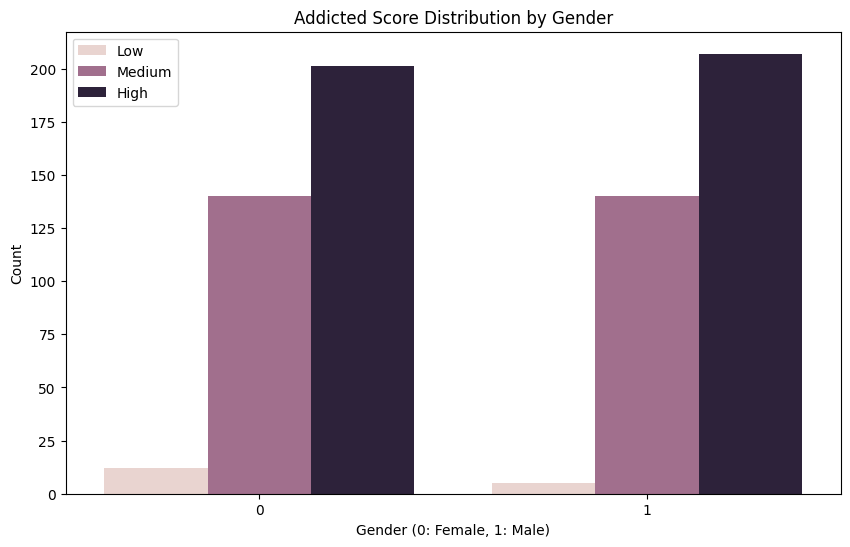

In [23]:
# Bar Graph: Addicted_Score by Gender
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Gender', hue='Addicted_Score_Category')
plt.title('Addicted Score Distribution by Gender')
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Count')
plt.legend(['Low', 'Medium', 'High'])
plt.show()

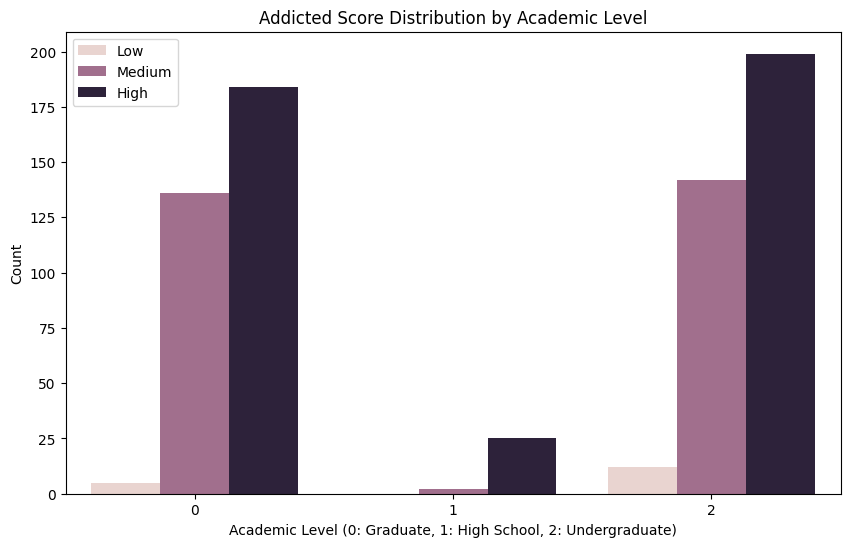

In [24]:
# Bar Graph: Addicted_Score by Academic_Level
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Academic_Level', hue='Addicted_Score_Category')
plt.title('Addicted Score Distribution by Academic Level')
plt.xlabel('Academic Level (0: Graduate, 1: High School, 2: Undergraduate)')
plt.ylabel('Count')
plt.legend(['Low', 'Medium', 'High'])
plt.show()

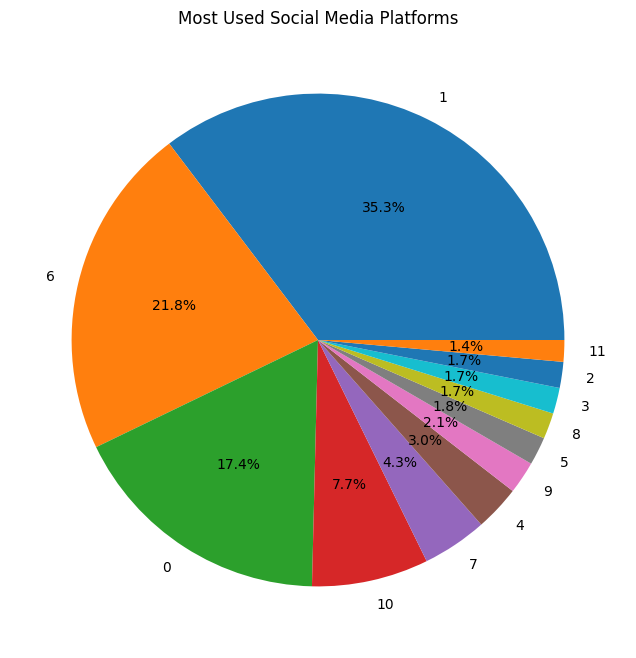

In [25]:
# Pie Chart: Most Used Platform
platform_counts = data['Most_Used_Platform'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(platform_counts, labels=platform_counts.index, autopct='%1.1f%%', startangle=0)
plt.title('Most Used Social Media Platforms')
plt.show()

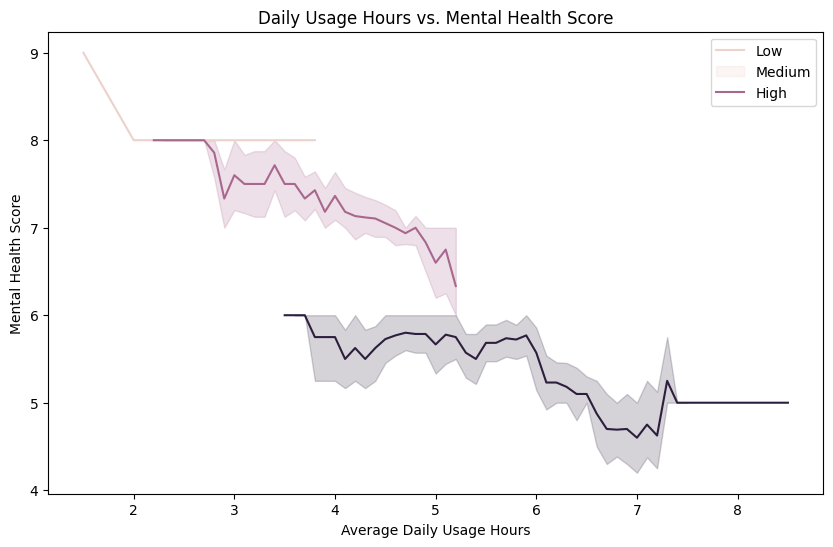

In [26]:
# Line Graph: Avg_Daily_Usage_Hours vs. Mental_Health_Score
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Avg_Daily_Usage_Hours', y='Mental_Health_Score', hue='Addicted_Score_Category')
plt.title('Daily Usage Hours vs. Mental Health Score')
plt.xlabel('Average Daily Usage Hours')
plt.ylabel('Mental Health Score')
plt.legend(['Low', 'Medium', 'High'])
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step


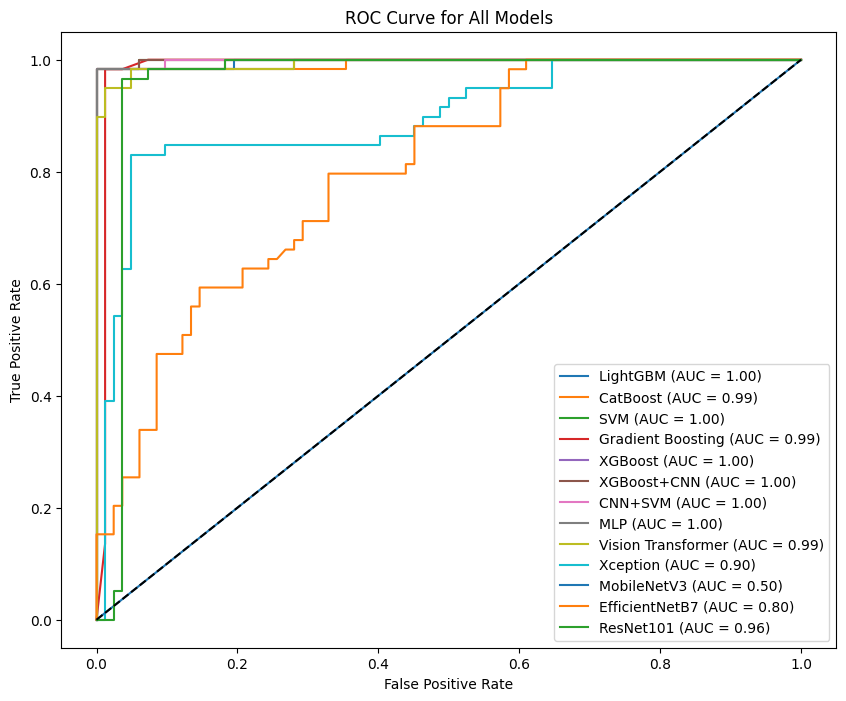

In [27]:
# ROC Curve for All Models
plt.figure(figsize=(10, 8))
for name, model in [('LightGBM', lgb), ('CatBoost', cat), ('SVM', svm), ('Gradient Boosting', gb), ('XGBoost', xgb)]:
    y_score = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

for name, model in [('XGBoost+CNN', hybrid_xgb_cnn_probs), ('CNN+SVM', hybrid_cnn_svm_probs)]:
    fpr, tpr, _ = roc_curve(y_test, model[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

for name, model in [('MLP', mlp), ('Vision Transformer', vit)]:
    y_score = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

for name, model in [('Xception', xception), ('MobileNetV3', mobilenet), ('EfficientNetB7', efficientnet), ('ResNet101', resnet)]:
    y_score = model.predict(X_test_image if name != 'Xception' else X_test_xception)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Models')
plt.legend(loc='best')
plt.show()

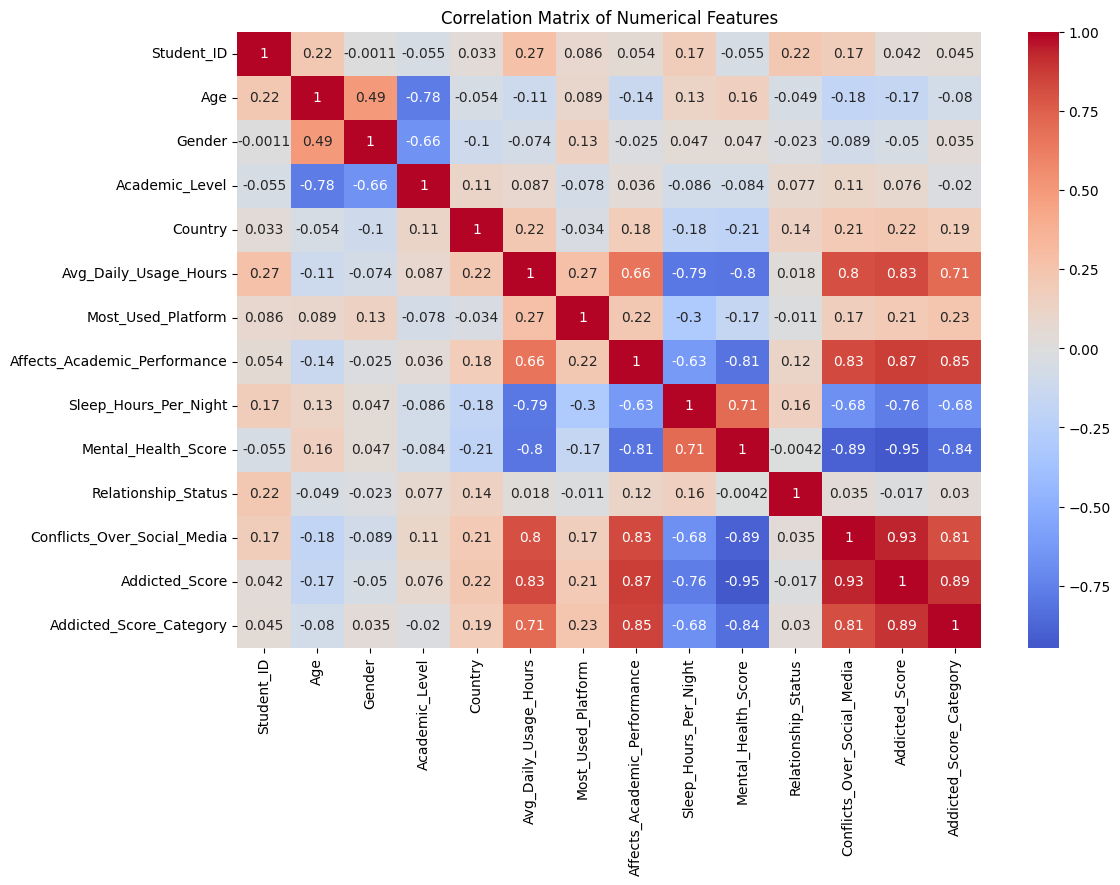

In [28]:

# Heatmap: Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [29]:
# Scatter Plot: Usage vs. Sleep Hours
fig = px.scatter(data, x='Avg_Daily_Usage_Hours', y='Sleep_Hours_Per_Night', color='Addicted_Score_Category', title='Usage vs. Sleep Hours')
fig.update_layout(xaxis_title='Average Daily Usage Hours', yaxis_title='Sleep Hours Per Night')
fig.update_traces(marker=dict(size=10))
fig.show()

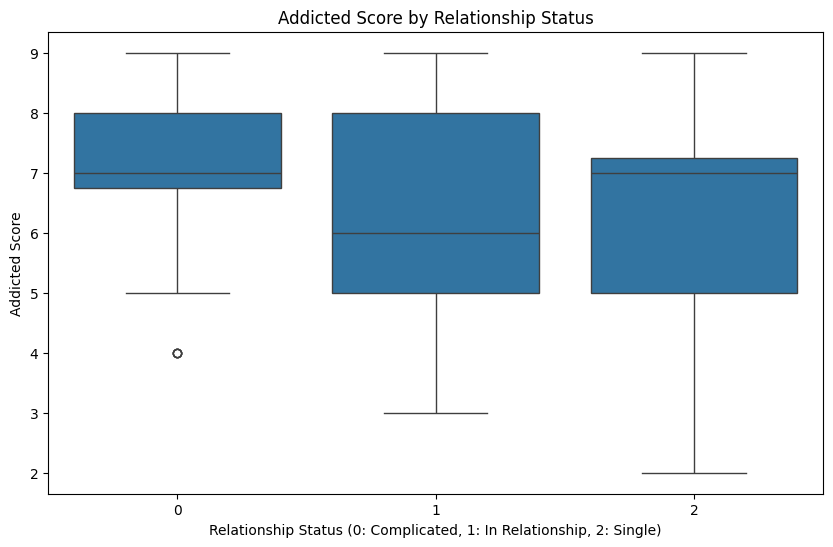

In [30]:
# Box Plot: Addicted_Score by Relationship_Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Relationship_Status', y='Addicted_Score')
plt.title('Addicted Score by Relationship Status')
plt.xlabel('Relationship Status (0: Complicated, 1: In Relationship, 2: Single)')
plt.ylabel('Addicted Score')
plt.show()


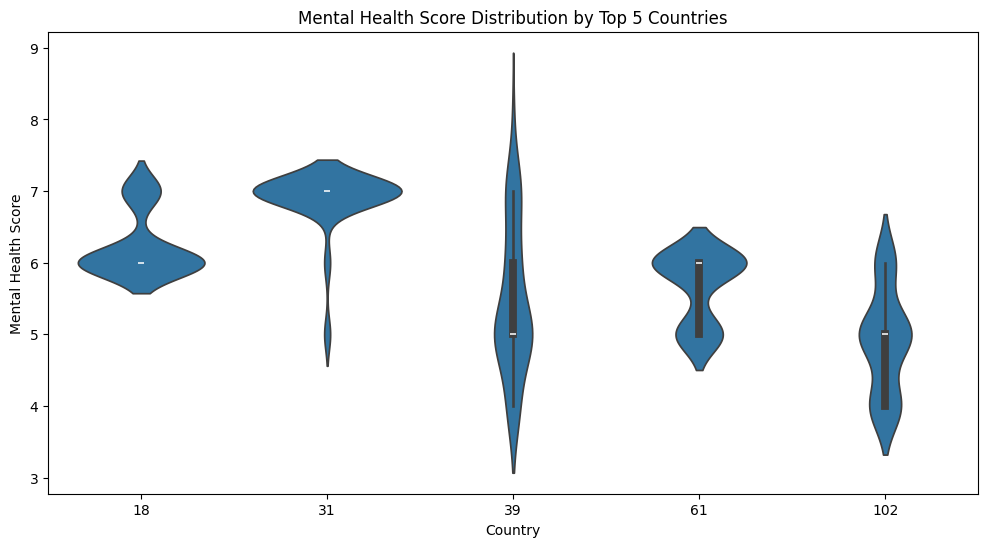

In [31]:
# Violin Plot: Mental_Health_Score by Country (Top 5 Countries)
top_countries = data['Country'].value_counts().index[:5]
filtered_data = data[data['Country'].isin(top_countries)]
plt.figure(figsize=(12, 6))
sns.violinplot(data=filtered_data, x='Country', y='Mental_Health_Score')
plt.title('Mental Health Score Distribution by Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Mental Health Score')
plt.show()

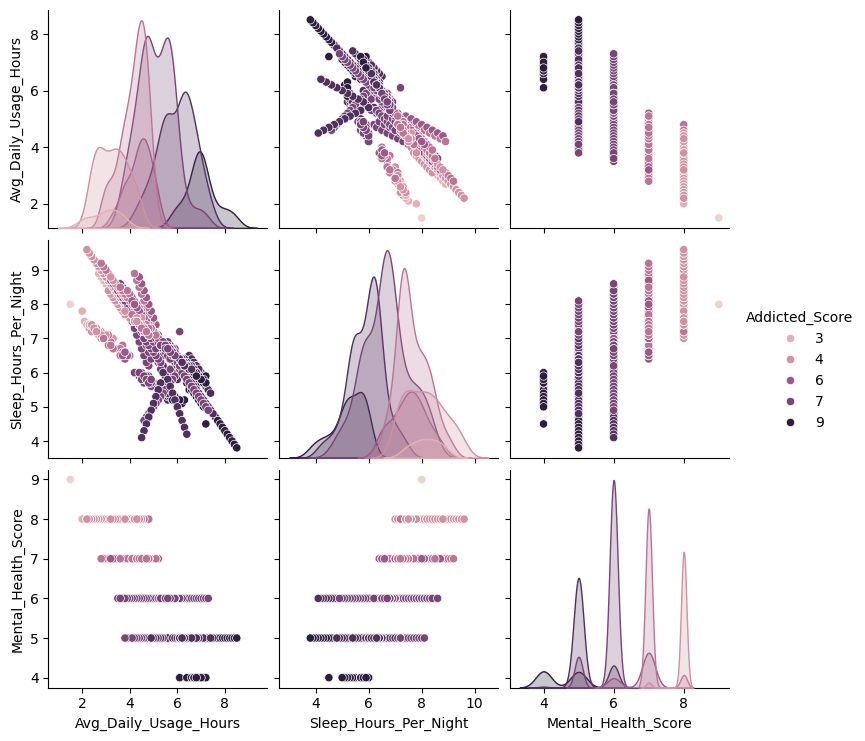

In [32]:
# Pair Plot
sns.pairplot(data[['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Addicted_Score']], hue='Addicted_Score')
plt.show()

<Figure size 1000x600 with 0 Axes>

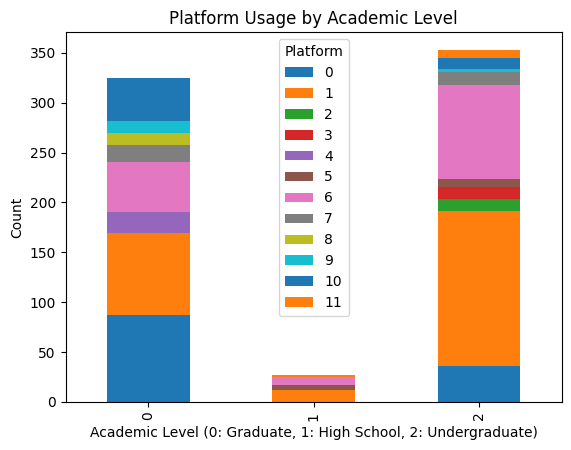

In [33]:
# Stacked Bar Chart: Platform Usage by Academic Level
platform_academic = data.groupby(['Academic_Level', 'Most_Used_Platform']).size().unstack().fillna(0)
plt.figure(figsize=(10, 6))
platform_academic.plot(kind='bar', stacked=True)
plt.title('Platform Usage by Academic Level')
plt.xlabel('Academic Level (0: Graduate, 1: High School, 2: Undergraduate)')
plt.ylabel('Count')
plt.legend(title='Platform')
plt.show()

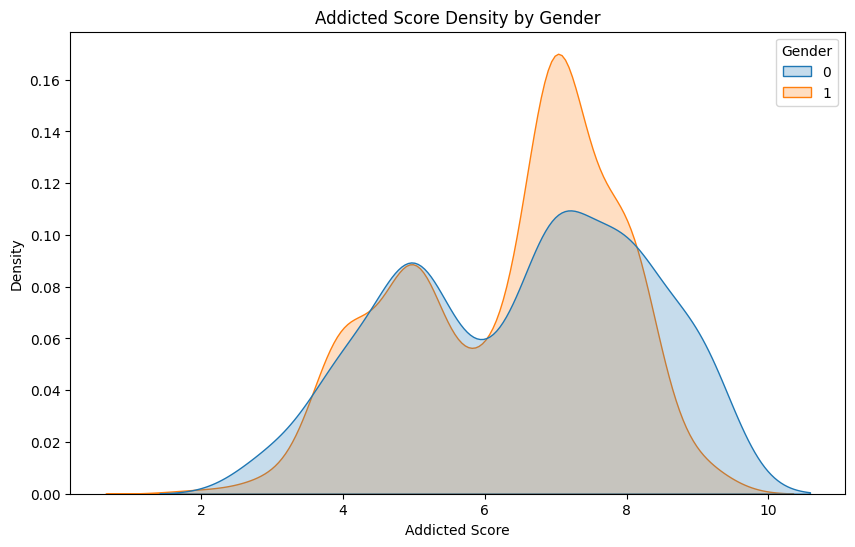

In [34]:
# KDE Plot: Addicted_Score by Gender
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='Addicted_Score', hue='Gender', fill=True)
plt.title('Addicted Score Density by Gender')
plt.xlabel('Addicted Score')
plt.ylabel('Density')
plt.show()